In [43]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from configparser import ConfigParser

from sklearn.metrics import accuracy_score, confusion_matrix

In [44]:
#Read config.ini file
config = ConfigParser()
config.read("config.ini")
dataset_info = config["DATASETS"]
fm_data_path = dataset_info['fm_path']
rf_data_path = dataset_info['rf_path']
train_set_filename = dataset_info['train_filename']
test_set_filename = dataset_info['test_filename']
description_filename = dataset_info['description_filename']

model_info = config["MODELS"]
model_path = model_info['model_path']
fm_filename = model_info['fm_model_filename']
rf_filename = model_info['rf_model_filename']

In [45]:
train = pickle.load(open(rf_data_path + train_set_filename, 'rb'))
test = pickle.load(open(rf_data_path + test_set_filename, 'rb'))

## Training data

In [46]:
X = train.drop((['rating']), axis = 1)
y = train['rating']

In [47]:
# Save for later reference, can be removed after all experiments
X_original = X.copy(deep = True)

## Test data

In [48]:
X_test = test.drop((['rating']), axis = 1)
y_test = test['rating']

Experimenting with one hot encoding occupation to see if performance increases. 
It was the same and this code is just for reference. Will be removed at the end.

In [49]:
X_ohe = X.copy(deep=True)
dummies = pd.get_dummies(X_ohe['occupation'], prefix = "occupation")
X_ohe.drop('occupation', axis = 1, inplace=True)
X_ohe = pd.concat([X_ohe, dummies], axis = 1)
dummies = pd.get_dummies(X_ohe['zip_code'], prefix = "zip_code")
X_ohe.drop('zip_code', axis = 1, inplace=True)
X_ohe = pd.concat([X_ohe, dummies], axis = 1)

In [51]:
X_test_ohe = X_test.copy(deep=True)
dummies = pd.get_dummies(X_test_ohe['occupation'], prefix = 'occupation')
X_test_ohe.drop('occupation', axis = 1, inplace=True)
X_test_ohe = pd.concat([X_test_ohe, dummies], axis = 1)
dummies = pd.get_dummies(X_test_ohe['zip_code'], prefix = "zip_code")
X_test_ohe.drop('zip_code', axis = 1, inplace=True)
X_test_ohe = pd.concat([X_test_ohe, dummies], axis = 1)

---
# 1. Feature importance using random forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
# initialize and fit the model
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_ohe, y)

RandomForestClassifier()

### Testing the model

In [56]:
y_pred = forest.predict(X_test_ohe)
accuracy_score(y_test, y_pred) * 100
# confusion_matrix(y_test, y_pred)

41.519321545723656

In [59]:
# list of column names
feature_names = list(X_ohe.columns)

# extract the feature importance values
rf_std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
rf_feature_importances = pd.DataFrame(
    {"feature": feature_names, "importance": forest.feature_importances_}
)

In [60]:
# giving colors for all genre for better visualization, optional
# my_colors = ['blue','green']
# my_colors.extend(['orange']*19)
# my_colors.extend(['brown','pink','gray','olive','cyan','aquamarine','gold','gold'])
# feature_importances_df['info'] = my_colors

In [61]:
rf_feature_importances.sort_values("importance", ascending=False,inplace=True)

In [62]:
# Converting the importances to percentage
rf_feature_importances['importance'] = rf_feature_importances['importance'] * 100

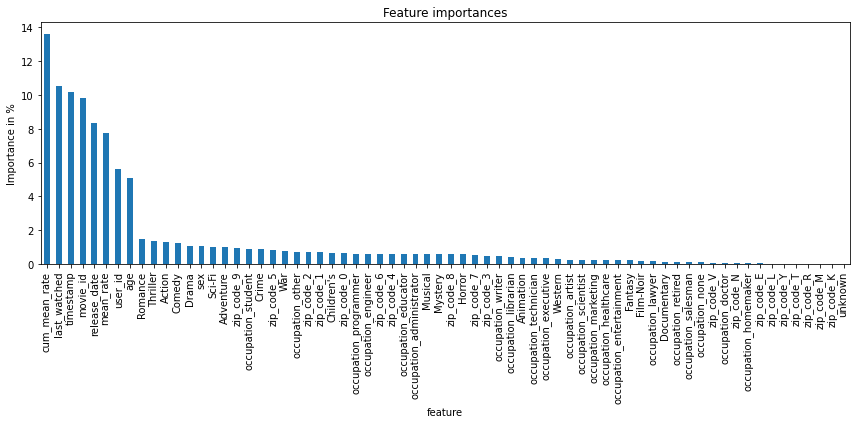

In [63]:
# visualize the importance of each feature
fig, ax = plt.subplots(figsize=(12,6))
# ax.set_ylim([0, 30])
rf_feature_importances.plot.bar(x='feature', y='importance', ax=ax, legend=False, stacked = True)
ax.set_title("Feature importances")
ax.set_ylabel("Importance in %")
fig.tight_layout()

---

# 2. Extra Tree Cassifier

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

In [33]:
extra_tree = ExtraTreesClassifier()
extra_tree.fit(X,y)

ExtraTreesClassifier()

In [34]:
# extract the feature importance values
et_std = np.std([tree.feature_importances_ for tree in extra_tree.estimators_], axis=0)
et_feature_importances = pd.DataFrame(
    {"feature": feature_names, "importance": extra_tree.feature_importances_}
)

In [35]:
et_feature_importances.sort_values("importance", ascending=False,inplace=True)

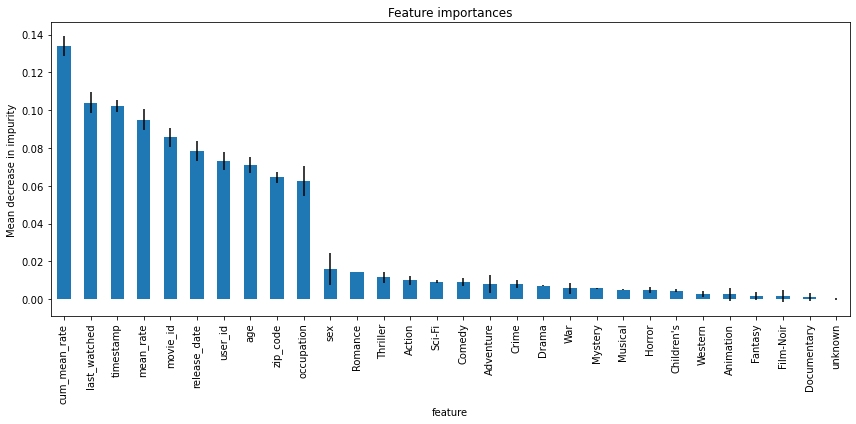

In [36]:
# visualize the importance of each feature
fig, ax = plt.subplots(figsize=(12,6))
et_feature_importances.plot.bar(x='feature', y='importance', yerr=et_std, ax=ax, legend=False)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Visualizing top 10 common features for random forest and extra trees

In [37]:
common_imp_features = pd.merge(rf_feature_importances.iloc[:11], et_feature_importances.iloc[:11], how = 'inner', on = ['feature'])
common_imp_features.rename(columns={'importance_x':'random_forest_importance','importance_y':'extra_tree_importance'}, inplace=True)

<AxesSubplot:xlabel='feature'>

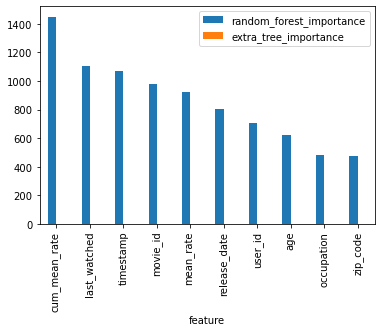

In [38]:
common_imp_features.plot.bar(x='feature', y=['random_forest_importance','extra_tree_importance'], legend=True)

both trees almost gave the same important features. These are the top 10 important features for our dataset.

In [40]:
from sklearn.inspection import permutation_importance
start_time = time.time()
result = permutation_importance(
    forest, X, y, n_repeats=4
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 211.291 seconds


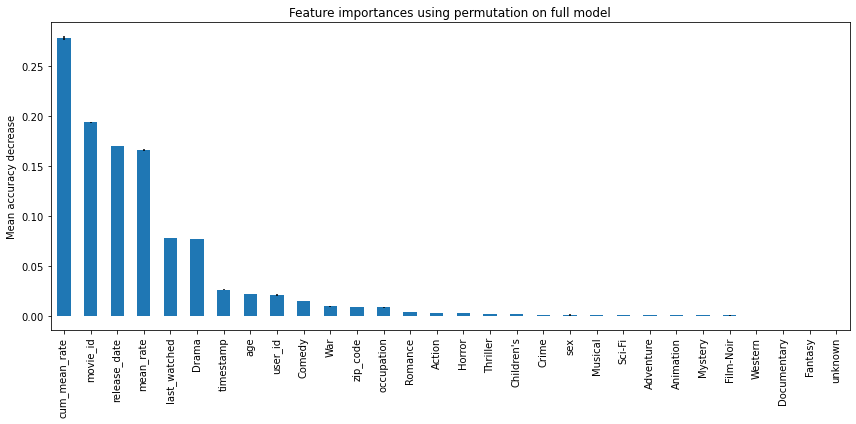

In [41]:
forest_importances.sort_values(ascending=False,inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [49]:
# Analysis - Correlation matrix with heatmap

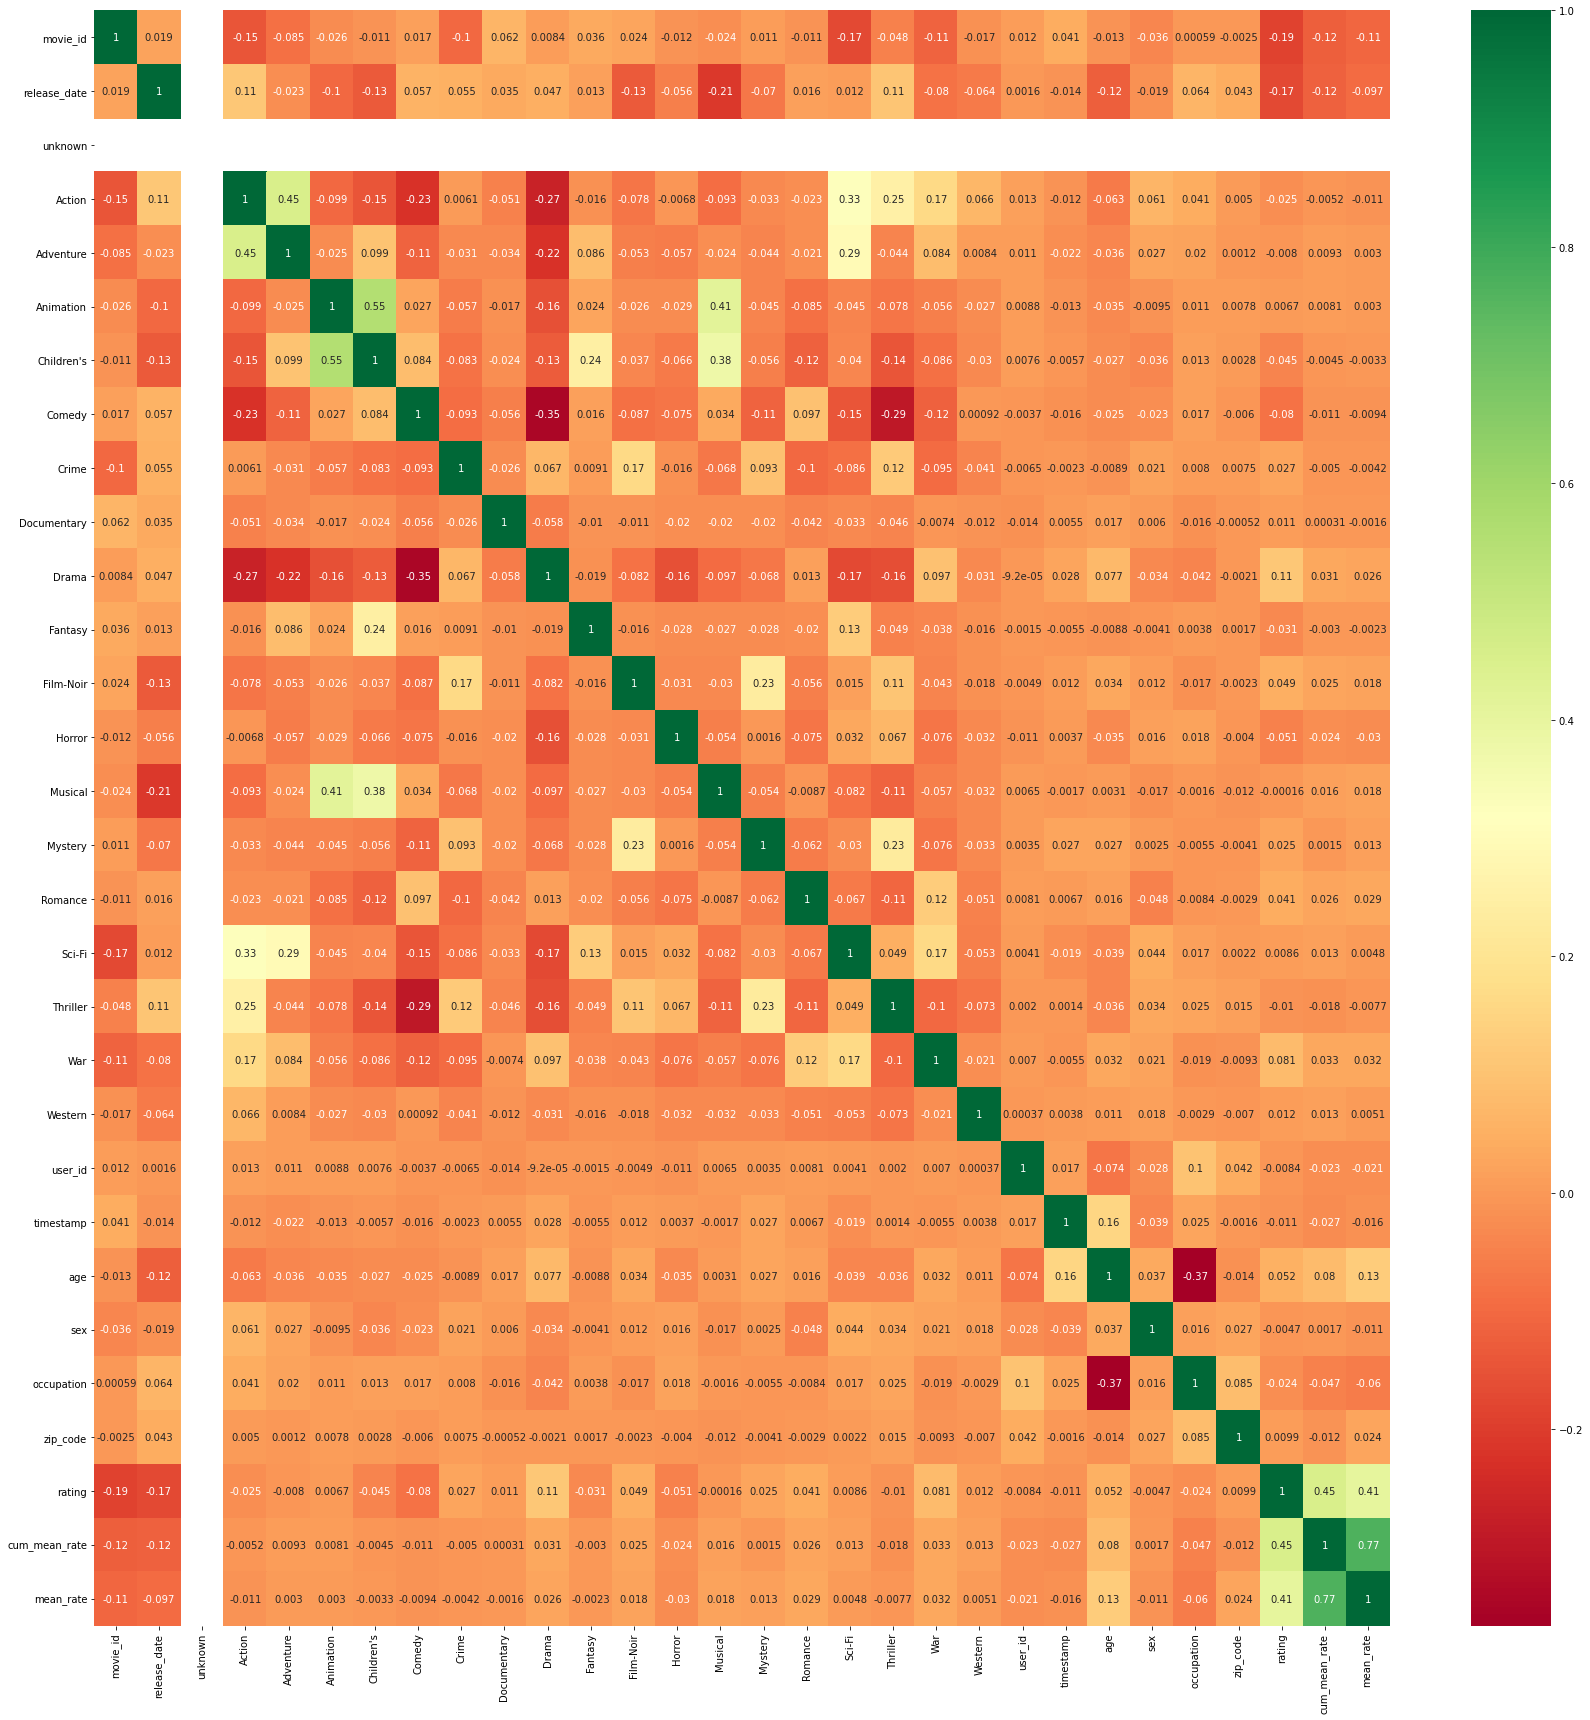

In [50]:
#get correlations of each features in dataset and plot heatmap
corrmat = df_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(24,24))
g=sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.tight_layout()

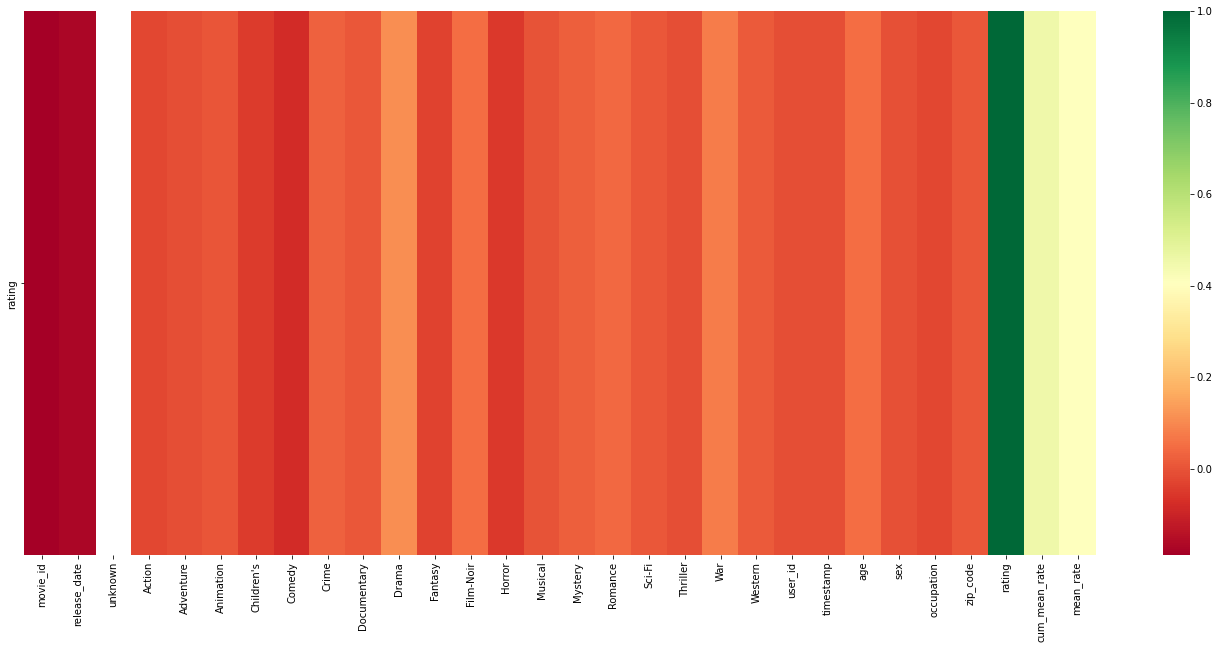

In [51]:
plt.figure(figsize=(24,10))
g2=sns.heatmap(pd.DataFrame(df_train[top_corr_features].corr().loc['rating']).T,annot=False,cmap="RdYlGn")

In [52]:
# this heatmap is to show which features are highly correlated with the output feature
# positive - increase in one value increases the target value and viceversa
# cummulative mean rating and and mean rating have high correlation with the rating. 
# this is because these features are extracted from rating. 
# movie id and release date don't have high correlation with the rating, but still those features are important. 

## Embedded methods

In [268]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [306]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)

In [316]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
sel_.fit(scaled, y)

SelectFromModel(estimator=LogisticRegression(C=1))

In [317]:
sel_.get_support()

array([ True,  True, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True])

In [323]:
selected_feat = X.columns[(sel_.get_support())]
print('total no of features: {}'.format((X.shape[1])))
print('No of selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total no of features: 29
No of selected features: 6
features with coefficients shrank to zero: 5


In [324]:
pd.DataFrame(selected_feat)

,0
0,movie_id
1,release_date
2,Children's
3,Drama
4,cum_mean_rate
5,mean_rate
